In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import pickle, keras

In [ ]:
data = pd.read_csv("CleanedFinalDateset/Airportfinaldata1.csv")
data.head()

,Date,Precipitation,Air Temperature,Relative Humidity,Wind Speed
0,2019-11-11 06:00,0.0,23.4,69.4,2.4
1,2019-11-11 07:00,0.0,24.3,64.7,2.5
2,2019-11-11 08:00,0.0,25.0,59.3,2.5
3,2019-11-11 09:00,0.0,25.4,57.5,2.4
4,2019-11-11 10:00,0.0,24.8,60.4,2.3


In [ ]:
#checking Null Data
data.isnull().sum()

Date                 0
Precipitation        0
Air Temperature      0
Relative Humidity    0
Wind Speed           0
dtype: int64

In [ ]:
data.describe()

,Precipitation,Air Temperature,Relative Humidity,Wind Speed
count,30051.000000,30051.000000,30051.000000,30051.000000
mean,0.488752,19.713673,83.803287,1.460531
std,2.861612,6.376164,19.684580,0.742332
min,0.000000,3.500000,30.000000,0.000000
25%,0.000000,14.600000,69.900000,0.900000
50%,0.000000,20.800000,93.700000,1.400000
75%,0.000000,24.200000,100.000000,1.900000
max,45.000000,37.200000,100.000000,8.000000


# Correlation between variables

<ipython-input-6-9f4fd9cd6ddc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


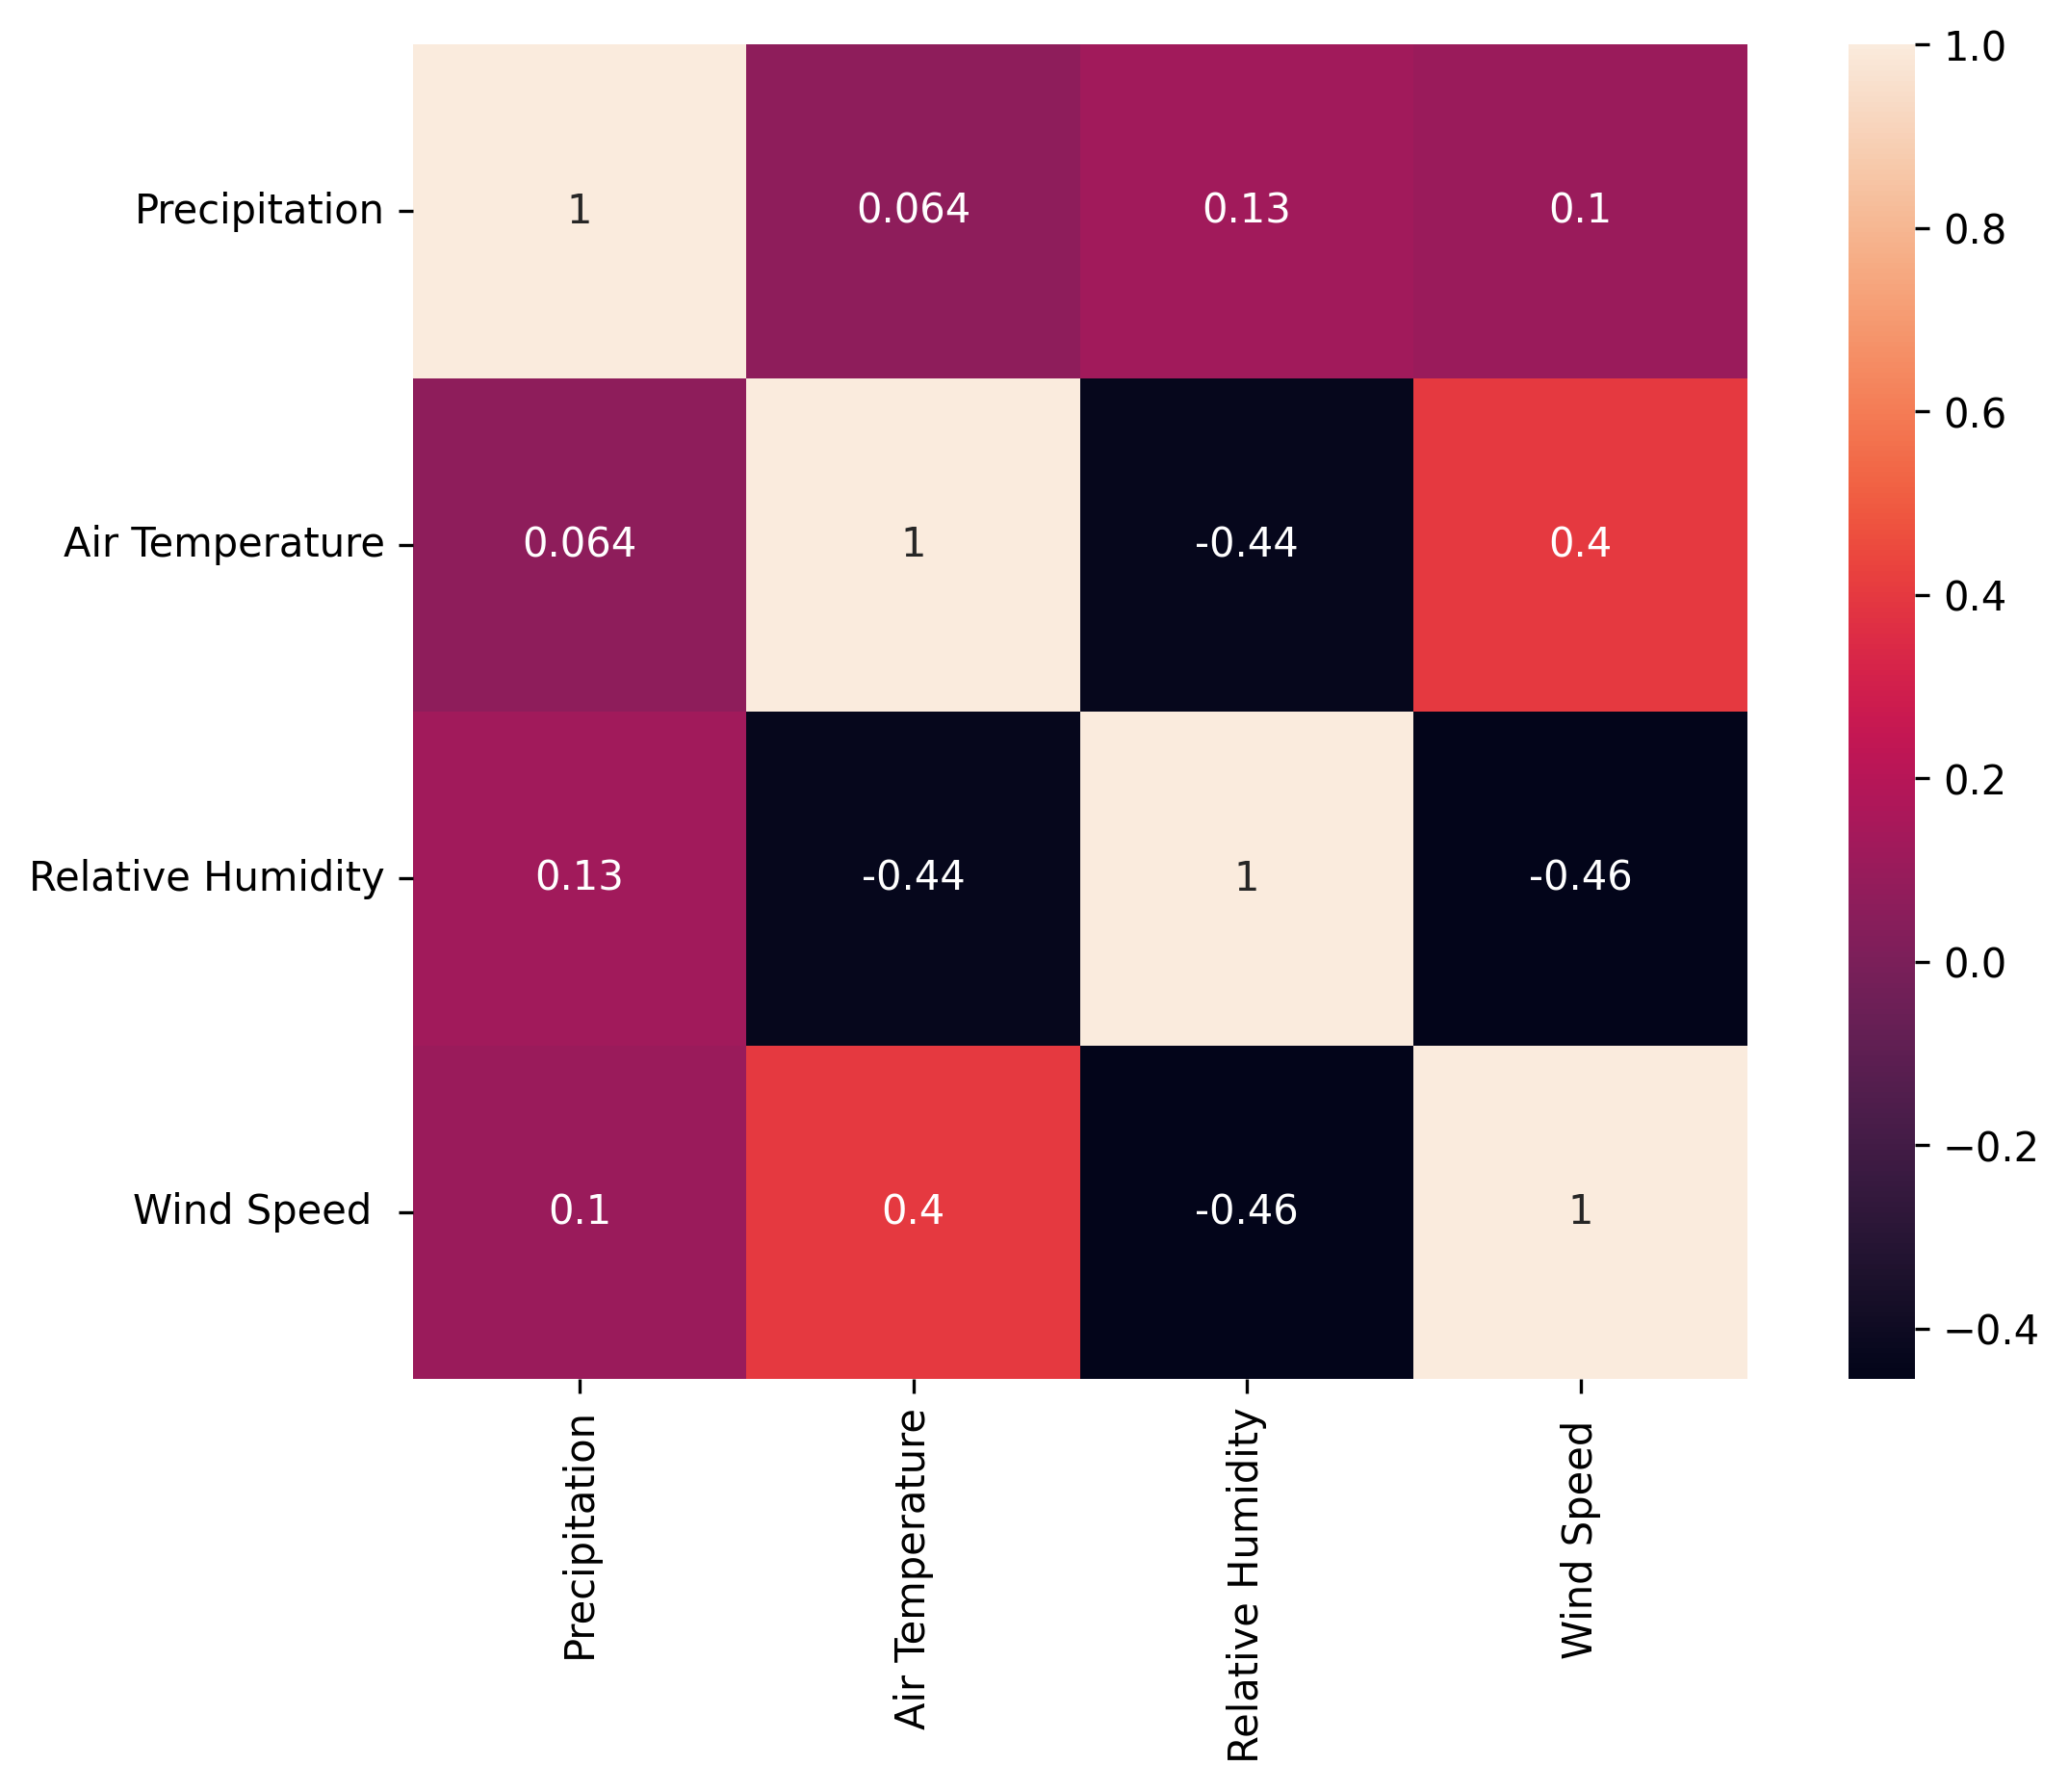

In [ ]:
# heat map of correlation of features
correlation_matrix = data.corr()
fig = plt.figure(figsize=(9,6),dpi=300)
sns.heatmap(correlation_matrix,vmax=1,square = True, annot= True)
plt.show()

# Extracting only data and exclusing the date

In [ ]:
#this can be used to implement dates to  plot the trend in future 
train_dates=pd.to_datetime(data['Date'])
cols = list(data)[1:5]
data_for_training= data[cols].astype(float)
data_for_training[20:30]

,Precipitation,Air Temperature,Relative Humidity,Wind Speed
20,0.0,15.9,100.0,0.9
21,0.0,17.1,100.0,1.0
22,0.0,18.9,98.2,1.1
23,0.0,21.5,79.9,1.7
24,0.0,23.3,64.7,2.1
25,0.0,24.2,62.0,2.6
26,0.0,24.9,56.8,2.4
27,0.0,25.0,55.1,2.3
28,0.0,24.8,55.5,2.4
29,0.0,24.1,61.0,1.8


# Normalizing the dataset 

In [ ]:
scaler=StandardScaler()
scaler.fit(data_for_training)
data_scaled=scaler.transform(data_for_training)

In [ ]:
#scaled dataset
data_scaled[20:30]

array([[-0.17079907, -0.59812396,  0.82282588, -0.75510739],
       [-0.17079907, -0.4099199 ,  0.82282588, -0.62039447],
       [-0.17079907, -0.12761382,  0.73138222, -0.48568154],
       [-0.17079907,  0.28016165, -0.19829492,  0.32259601],
       [-0.17079907,  0.56246774, -0.97048578,  0.86144771],
       [-0.17079907,  0.70362078, -1.10765126,  1.53501234],
       [-0.17079907,  0.81340648, -1.37182181,  1.26558649],
       [-0.17079907,  0.82909015, -1.45818526,  1.13087357],
       [-0.17079907,  0.79772281, -1.43786445,  1.26558649],
       [-0.17079907,  0.68793711, -1.15845329,  0.45730894]])

# Data preparation for Windowing

In [ ]:
# multi-step data preparation
from numpy import array
def split_sequence(data_scaled, n_past, n_future):
  X, y = list(), list()
  for i in range(len(data_scaled)):
# find the end of this pattern
    end_ix = i + n_past
    out_end_ix = end_ix + n_future
# check if we are beyond the sequence
    if out_end_ix > len(data_scaled):
      break
# gather input and output parts of the pattern
    seq_x, seq_y = data_scaled[i:end_ix,0:4], data_scaled[end_ix:out_end_ix,1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
# choose a number of time steps
n_past, n_future = 24, 2
# split into samples
X, y = split_sequence(data_scaled, n_past, n_future)


In [ ]:
X,y=np.array(X), np.array(y)
#DATA
X.shape, y.shape

((30026, 24, 4), (30026, 2))

In [ ]:
X[:2]

array([[[-0.17079907,  0.57815141, -0.73171624,  1.26558649],
        [-0.17079907,  0.71930445, -0.97048578,  1.40029942],
        [-0.17079907,  0.82909015, -1.24481674,  1.40029942],
        [-0.17079907,  0.89182484, -1.33626039,  1.26558649],
        [-0.17079907,  0.79772281, -1.18893451,  1.13087357],
        [-0.17079907,  0.56246774, -0.78251827,  0.32259601],
        [-0.17079907,  0.37426368, -0.1627335 , -0.35096861],
        [-0.17079907,  0.31152899, -0.16781371, -0.48568154],
        [-0.17079907,  0.21742696,  0.05571523, -0.88982032],
        [-0.17079907,  0.04490657,  0.56373552, -1.15924617],
        [-0.17079907, -0.06487913,  0.82282588, -0.35096861],
        [-0.17079907, -0.11193014,  0.82282588, -0.48568154],
        [-0.17079907, -0.22171585,  0.82282588, -0.62039447],
        [-0.17079907, -0.31581787,  0.82282588, -0.75510739],
        [-0.17079907, -0.36286889,  0.82282588, -1.29395909],
        [-0.17079907, -0.3001342 ,  0.82282588, -1.15924617],
        

In [ ]:
y[1]

array([0.70362078, 0.81340648])

In [ ]:
#printing the shape:
print("The Training data i.e X shape: {}." .format(X.shape))
print("The result data  i.w y shape: {}." .format(y.shape))

The Training data i.e X shape: (30026, 24, 4).
The result data  i.w y shape: (30026, 2).


# Splitting the data into training validation and Testing


In [ ]:
# Split the data into training, validation, and test sets
num_samples = X.shape[0]
training_samples = int(np.round(num_samples * 0.8))
validation_samples = int(np.round(num_samples * 0.1))
test_samples = num_samples - training_samples - validation_samples

X_train = X[:training_samples,:]
y_train = y[:training_samples]

X_val = X[training_samples:training_samples+validation_samples,:]
y_val = y[training_samples:training_samples+validation_samples]

X_test = X[training_samples+validation_samples:,:]
y_test = y[training_samples+validation_samples:]

In [ ]:
#shapes of training, validation and test dataset:
X_train.shape,y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape

((24021, 24, 4),
 (24021, 2),
 (3003, 24, 4),
 (3003, 2),
 (3002, 24, 4),
 (3002, 2))

# Bidirectional LSTM

In [ ]:
#Modeling 
model1 = Sequential()
model1.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True ), input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model1.add(Bidirectional(LSTM(64,activation='relu',return_sequences=True)))
model1.add(Bidirectional(LSTM(64,activation='relu')))
model1.add(Dense(y_train.shape[1], activation='linear'))

In [ ]:
#check Points of model for the saving the model
cp1= ModelCheckpoint('model1/HourlyTemperaturemodel.h5', best_model_only=True)

In [ ]:
#Compile the Model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics='accuracy')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 128)          35328     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 24, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 2

In [ ]:
history=model1.fit(X_train,y_train, epochs=20, validation_data=(X_val,y_val), batch_size=64, callbacks=[cp1])

Epoch 1/20
376/376 [==============================] - 95s 226ms/step - loss: 0.1588 - accuracy: 0.7397 - val_loss: 0.0471 - val_accuracy: 0.7955
Epoch 2/20
376/376 [==============================] - 83s 220ms/step - loss: 0.0406 - accuracy: 0.8081 - val_loss: 0.0371 - val_accuracy: 0.8052
Epoch 3/20
376/376 [==============================] - 82s 218ms/step - loss: 0.0308 - accuracy: 0.8279 - val_loss: 0.0327 - val_accuracy: 0.7962
Epoch 4/20
376/376 [==============================] - 82s 218ms/step - loss: 0.0257 - accuracy: 0.8354 - val_loss: 0.0299 - val_accuracy: 0.8019
Epoch 5/20
376/376 [==============================] - 87s 233ms/step - loss: 0.0238 - accuracy: 0.8408 - val_loss: 0.0237 - val_accuracy: 0.8082
Epoch 6/20
376/376 [==============================] - 80s 213ms/step - loss: 0.0229 - accuracy: 0.8446 - val_loss: 0.0214 - val_accuracy: 0.8478
Epoch 7/20
376/376 [==============================] - 82s 219ms/step - loss: 0.0215 - accuracy: 0.8458 - val_loss: 0.0249 - val_ac

# Testing the training and validation Accuracy

In [ ]:
#Testing the training accuracy
#train_predictions=model1.predict(X_train).flatten()
#changing to the 1d to compare the result
#y_train1d=y_train.flatten()
#train_results=pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals': y_train1d})
#train_results

train_predictions=model1.predict(X_train)
train_prediction_avg=np.mean(train_predictions, axis=1)
y_train1d=np.mean(y_train, axis=1)
train_results=pd.DataFrame(data={'Train Predictions':train_prediction_avg, 'Actuals': y_train1d})
train_results

751/751 [==============================] - 30s 39ms/step


,Train Predictions,Actuals
0,0.677628,0.633044
1,0.833070,0.758514
2,0.752906,0.821248
3,0.748868,0.813406
4,0.605636,0.742830
...,...,...
24016,0.487768,0.531100
24017,0.558749,0.515417
24018,0.622887,0.515417
24019,0.669484,0.593835


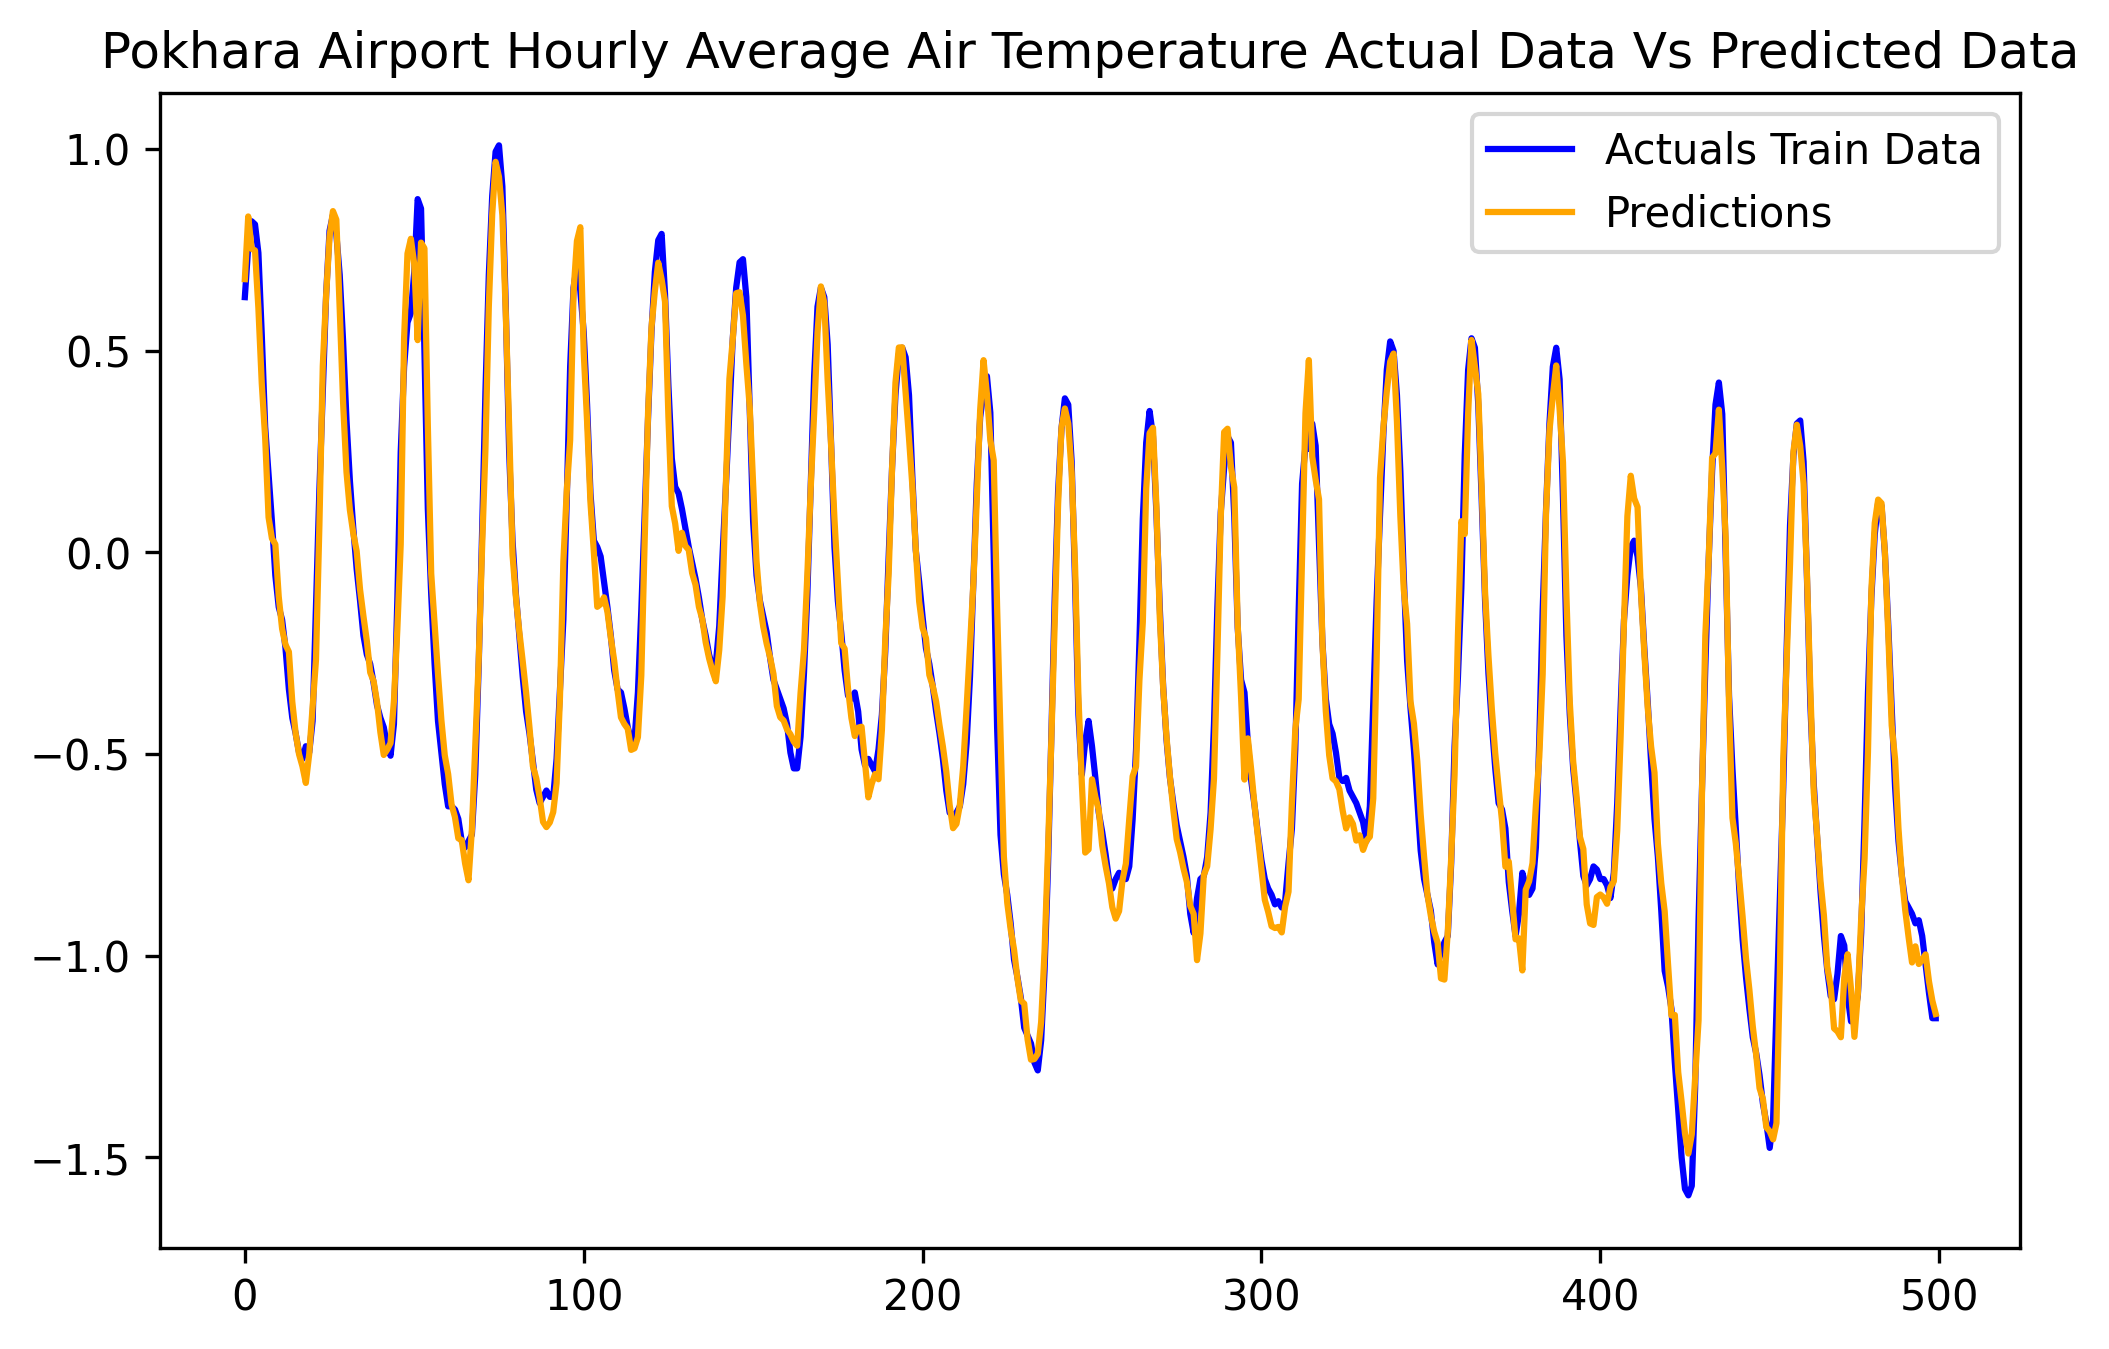

In [ ]:
#plotting the training results:
plt.figure(figsize=(8,5), dpi=300)
# Create a plot
plt.plot(y_train1d[:500],color='blue', linewidth=1.5, label='Actuals Train Data')
plt.plot(train_prediction_avg[0:500], color='orange', linewidth=1.5, label='Predictions')
plt.title('Pokhara Airport Hourly Average Air Temperature Actual Data Vs Predicted Data')
# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
#Testing the Test data  accuracy
#flatten will give only the 2d into 1d  so it shifts the data to some extent of right hence to not shifting this data we calculate the 
#mean so that this will give the better visualization
#test_predictions=model1.predict(X_test).flatten()
test_predictions=model1.predict(X_test)
test_prediction_avg=np.mean(test_predictions, axis=1)
y_test1d=np.mean(y_test, axis=1)
test_results=pd.DataFrame(data={'Test Predictions':test_prediction_avg, 'Actuals': y_test1d})
test_results

94/94 [==============================] - 2s 26ms/step


,Test Predictions,Actuals
0,-0.776083,-0.480496
1,-0.361462,-0.064879
2,0.051353,0.131167
3,0.143613,0.186060
4,0.011585,0.084116
...,...,...
2997,0.173775,0.433077
2998,0.650422,0.864378
2999,1.070173,1.252549
3000,1.350034,1.558381


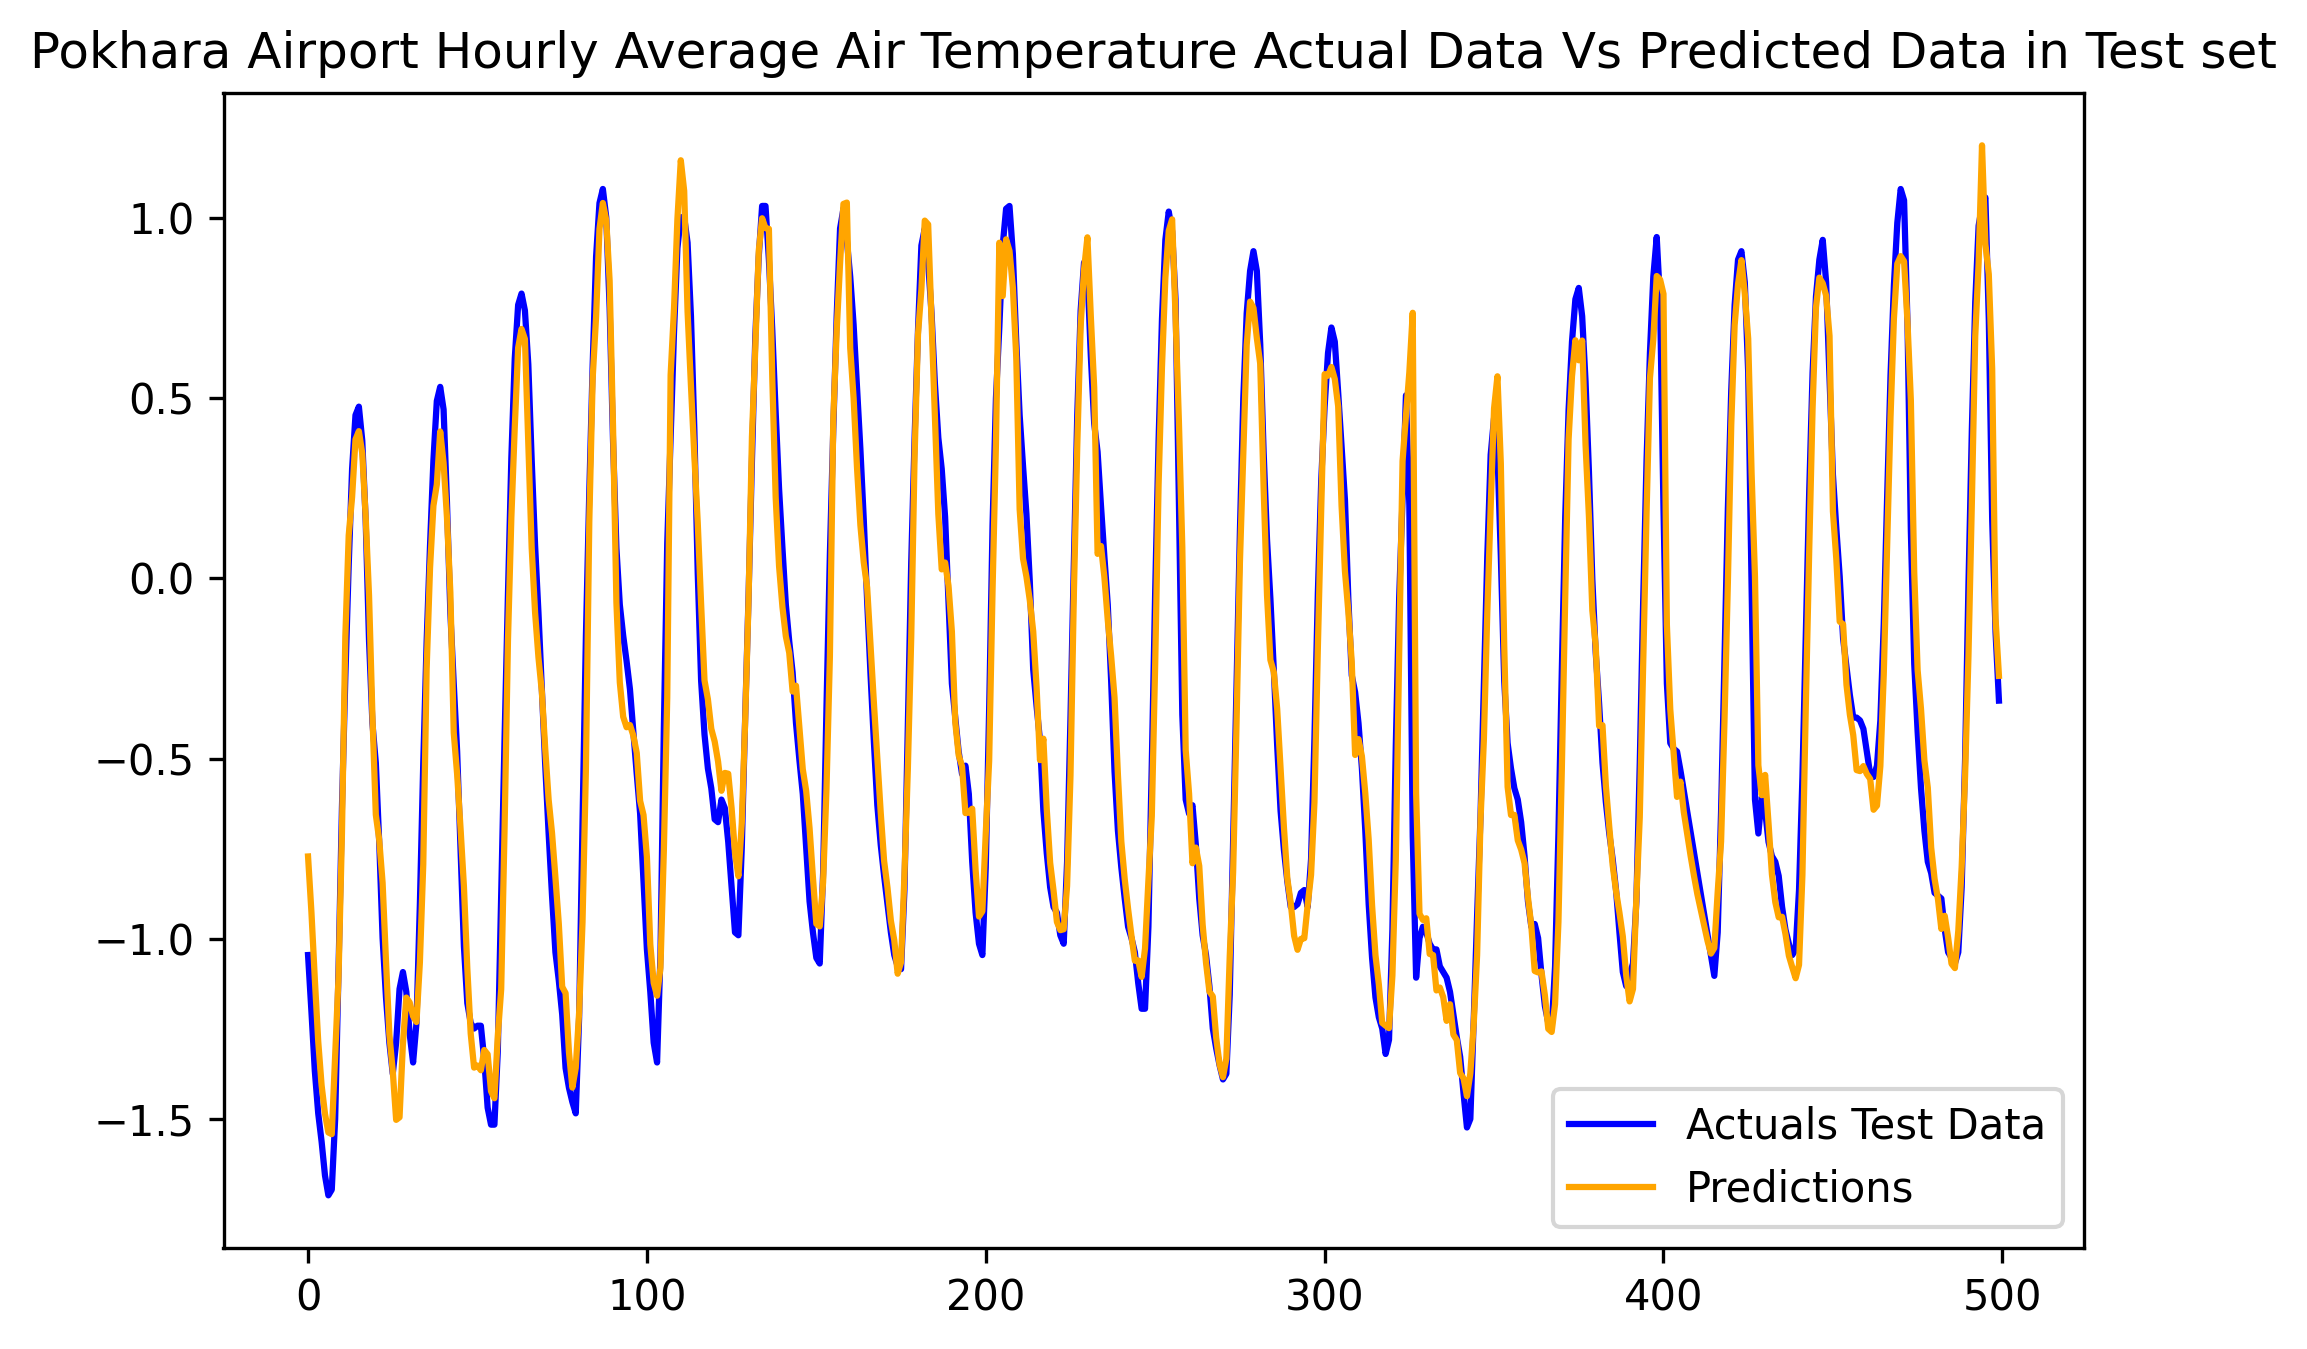

In [ ]:
#plotting the testing results:
plt.figure(figsize=(8,5), dpi=300)
# Create a plot
plt.plot(y_test1d[1500:2000], color='blue', linewidth=1.5, label='Actuals Test Data')
plt.plot(test_prediction_avg[1500:2000],color='orange', linewidth=1.5, label='Predictions')
plt.title('Pokhara Airport Hourly Average Air Temperature Actual Data Vs Predicted Data in Test set')
# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# save the model and scaler to a file
with open('/content/model1/Airporthourlytemperature.pkl', 'wb') as f:
    pickle.dump((model1, scaler), f)

# Training and validation loss over epoches


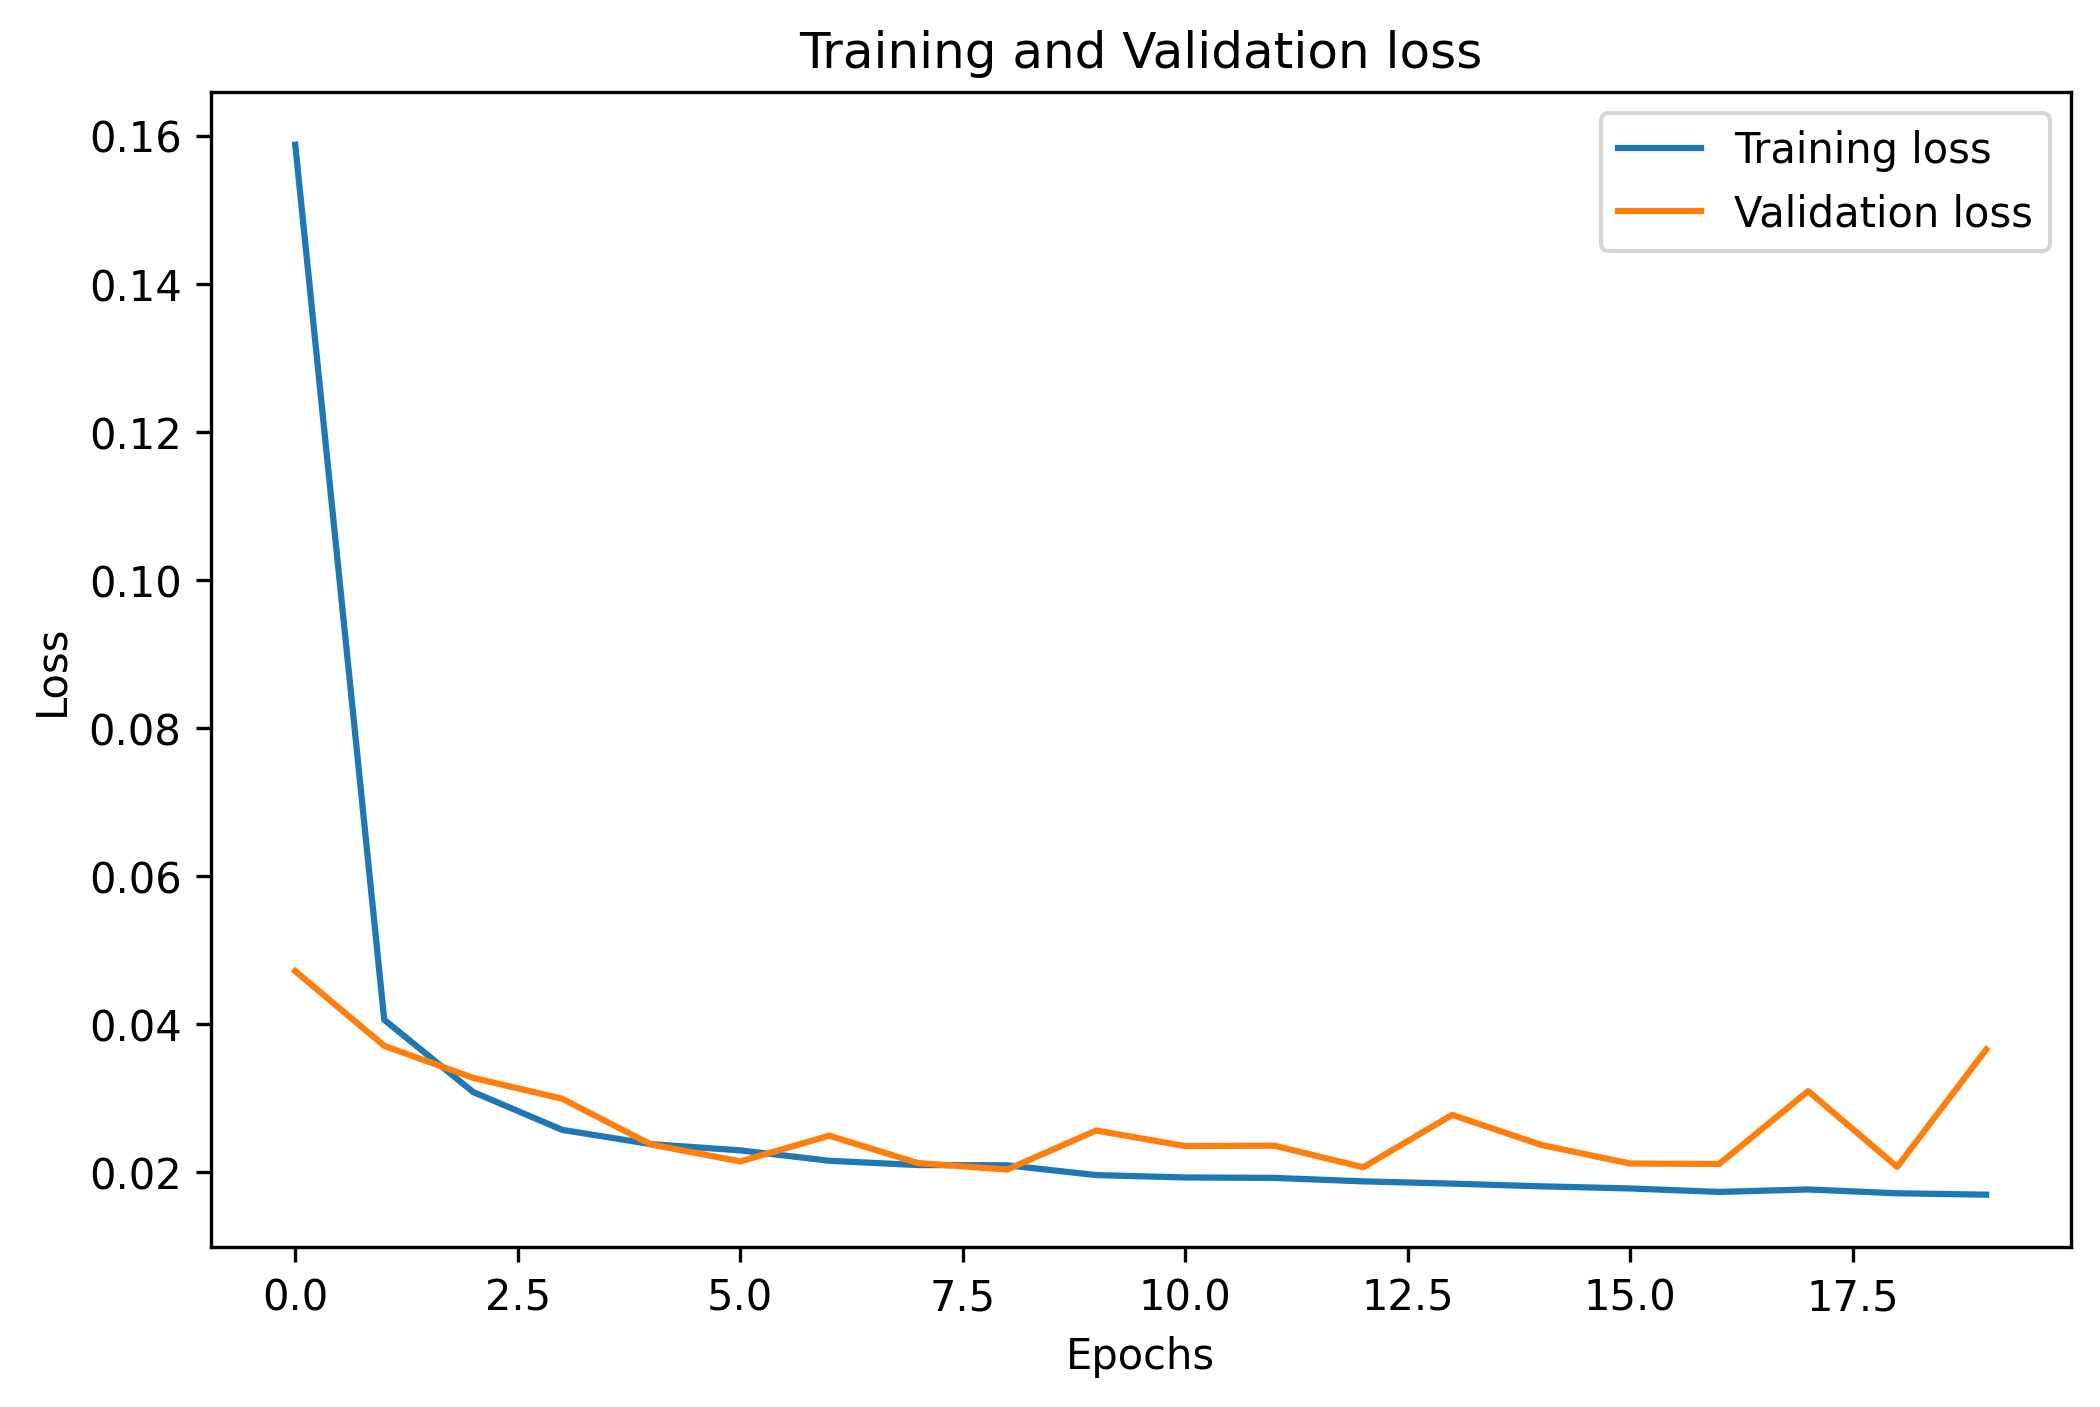

In [ ]:
#to plot the loss over the training and validation epoch we can do now as 
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(8,5), dpi=300)
plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

# RMSE MAE and R2 of Training and testing


In [ ]:
#training
train_error =y_train1d- train_prediction_avg
squared_train_error = train_error ** 2
mean_squared_error = np.mean(squared_train_error)
rmse = np.sqrt(mean_squared_error)

print("RMSE:", rmse)

RMSE: 0.11390621670324907


In [ ]:
#Testing
error = y_test1d - test_prediction_avg
squared_error = error ** 2
mean_squared_error = np.mean(squared_error)
rmse = np.sqrt(mean_squared_error)

print("RMSE:", rmse)

RMSE: 0.156507285565814


In [ ]:
from sklearn.metrics import r2_score
r2_train = r2_score(y_train1d, train_prediction_avg)
r2_train

0.9868717901082311

In [ ]:
from sklearn.metrics import r2_score
r2_test = r2_score(y_test1d, test_prediction_avg)
r2_test

0.968482361327571

In [ ]:
#calculating the MAE error of train and test 
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train1d, train_prediction_avg)
mae_test = mean_absolute_error(y_test1d, test_prediction_avg)
print(mae_train,mae_test)

0.07840373075601774 0.11320917505049033
